In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan, pickle
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# %matplotlib inline

In [3]:
stancode = """
functions {
            real[] SIR(real t,  // time
            real[] u,           // system state {infected,cases,susceptible}
            real[] theta,       // parameters 
            real[] x_r,
            int[] x_i) {

            real du_dt[6];
        
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real sigmau = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            
            real I = u[1];  # unknown infected
            real C = u[2];  # cases
            
            real m;
            real c;
            
            m = mbase + (1-mbase)/(1 + exp(mrate*(t - mlocation)));            
            
            c = 1 + cmax*t/(c50+t);
            
            beta *= m;
            sigmac *= c;
            
            du_dt[1] = beta*(I+q*C) - sigmac*I - sigmau*I; //I
            du_dt[2] = sigmac*I - (sigmar+sigmad)*C; //C
            du_dt[3] = beta*(I+q*C); //N_I
            du_dt[4] = sigmac*I; //N_C case appearance rate
            du_dt[5] = sigmar*C; // R_C appearance rate
            du_dt[6] = sigmad*C; // D_C appearance rate
            
            return du_dt;
          }
            
          
        }

        data {
          int<lower = 1> n_obs;       // number of days observed
          int<lower = 1> n_theta;     // number of model parameters
          int<lower = 1> n_difeq;     // number of differential equations for yhat
          int<lower = 1> n_ostates;   // number of observed states
          real<lower = 1> n_scale;    // scale to match observed scale
          int y[n_obs,n_ostates];     // data, per-day-tally [cases,recovered,death]
          real t0;                    // initial time point 
          real tm;                    //start day of mitigation
          real ts[n_obs];             // time points that were observed
          }

        transformed data {
            real x_r[0];
            int x_i[0];           
        }

        parameters {
            real<lower = 0> theta[n_theta]; // model parameters 
        }

        transformed parameters{
            real u[n_obs, n_difeq]; // solution from the ODE solver
            real u_init[n_difeq];     // initial conditions for fractions
            
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real sigmau = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            real theta_init = theta[12];
            
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered] 
                
            // What ODE system is expecting:    
            // beta -> beta*m(t), sigmac -> sigmac*c(t)
            //du_dt[1] = beta*(I+q*C) - sigmac*c(t)*I - sigmau*I; //I
            //du_dt[2] = sigmac*c(t)*I - (sigmar+sigmad)*C; //C
            //du_dt[3] = beta*(I+q*C); //N_I
            //du_dt[4] = sigmac*I; //N_C
            //du_dt[5] = sigmar*C;// sigmarC
            //du_dt[6] = sigmad*C; // sigmadD                     
                        
            u_init[1] = theta_init/n_scale; // I
            u_init[2] = y[1,1]/n_scale; //C
            u_init[3] = u_init[1];  //N_I
            u_init[4] = u_init[2] ;  //N_C
            u_init[5] = 0;  //sigmarC
            u_init[6] = 0;  //sigmadD 
            
            //print(theta)
            u = integrate_ode_rk45(SIR, u_init, t0, ts, theta, x_r, x_i);
            
            //lambda
            lambda[1,1] = (u[1,4]-u_init[4])*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = (u[1,5]-u_init[5])*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = (u[1,6]-u_init[6])*n_scale; //D: dead sigma_d * \int C
        
            for (i in 2:n_obs){
                lambda[i,1] = (u[i,4]-u[i-1,4])*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = (u[i,5]-u[i-1,5])*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = (u[i,6]-u[i-1,6])*n_scale; //D: dead
            
            }
  
        }

        model {
  
            //priors
            
            //for (i in 1:n_theta){theta[1] ~ lognormal(log(0.1),10);};
            //theta[5] ~ lognormal(log(0.25),10);
            
            
            //real beta = theta[1];
            //real sigmac = theta[2];
            //real sigmar = theta[3];
            //real sigmad =  theta[4];
            //real q = theta[5]; 
            //real sigmau = theta[6]; 
            //real mbase = theta[7]; 
            //real mlocation = theta[8]; 
            //real mrate = theta[9]; 
            //real cmax = theta[10];
            //real c50 = theta[11];
            
            // [0.25,
            //0.1,
            //0.01,
            //0.01,
            //0.01,
            //1.0,
            //0.1,
            //1.0,
            //1.0,
            //0.1,
            //10.0,
            //1.0]

            theta[1] ~ lognormal(log(0.25),1); //beta 
            theta[2] ~ lognormal(log(0.1),1); //sigmac
            theta[3] ~ lognormal(log(0.01),1); //sigmar
            theta[4] ~ lognormal(log(0.01),1); //sigmad
            theta[5] ~ lognormal(log(0.01),1); //q
            theta[6] ~ lognormal(log(0.01),1); //sigmau
            theta[7] ~ lognormal(log(0.1),1); //mbase  
            theta[8] ~ lognormal(log(tm),5); //mlocation 
            theta[9] ~ lognormal(log(1),5); //mrate
            theta[10] ~ lognormal(log(0.1),1);//cmax 
            theta[11] ~ lognormal(log(10),1);//c50 
            theta[12] ~ lognormal(log(1),0.1);// theta_init 

          
            //likelihood
            //lambda[1,1] = (u[1,4]-u_init[4])*sigmac*n_scale; //C: cases sigma_c*\int I
            //lambda[1,2] = (u[1,5]-u_init[5])*sigmar*n_scale; //R: recovered sigma_r*\int C
            //lambda[1,3] = (u[1,6]-u_init[6])*sigmad*n_scale; //D: dead sigma_d * \int C
        
            target += poisson_lpmf(y[1,1]|max([lambda[1,1],0.0])); //C
            target += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0])); //R
            target += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0])); //D

            
            for (i in 2:n_obs){
                target += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0])); //C
                target += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0])); //R
                target += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0])); //D
            }

        }

        generated quantities {
        
            real ll_; // log-likelihood for model
         
            //likelihood
            ll_ = poisson_lpmf(y[1,1]|max([lambda[1,1],0.0]));
            ll_ += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0]));
            ll_ += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0]));

            
            for (i in 2:n_obs){
                ll_ += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0]));
                ll_ += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0]));
                ll_ += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0]));
            }
            
            print(ll_)
         
        }
        """

In [4]:
# stanrunmodel = pystan.StanModel(model_code=stancode)

# with open('stanrunmodel.pkl', 'wb') as f:
#    pickle.dump(stanrunmodel, f)

stanrunmodel = pickle.load(open('stanrunmodel.pkl', 'rb'))


# Load data from Gerkin scrape

In [5]:
roi = "US_MI"

t0 index assumed to be: day 8
t0 date: 03/13/20
tm index assumed to be: day 18
mitigation date: 03/23/20


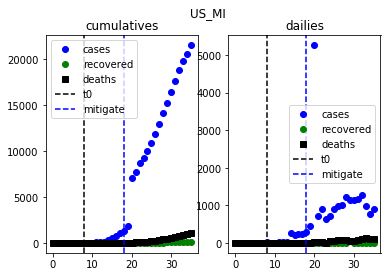

In [6]:
DF = pd.read_csv("../data/covid_timeseries_"+roi+".csv")

# pop = {}
# pop['Italy'] = 60500000
# pop['United Kingdom'] = 64400000
# pop['France'] = 66990000
# pop['Netherlands'] = 17000000

# mitigate = {}
# mitigate['Italy'] = '3/9/20' #approximate date
# mitigate['Netherlands'] = '3/12/20' #approximate date

# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=10)[0][0] 
# tm := start of mitigation, index space
tm = t0 + 10 #np.where(mitigate[roi]==DF['dates2'])[0][0]

#plot the data with important time stamps (t0, tm)
plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"],'bo', label="cases")
plt.plot(DF["cum_recover"],'go',label="recovered")
plt.plot(DF["cum_deaths"],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["new_cases"],'bo', label="cases")
plt.plot(DF["new_recover"],'go',label="recovered")
plt.plot(DF["new_deaths"],'ks',label="deaths")
plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.suptitle(roi)
plt.legend()


print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+DF['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
print("mitigation date: "+DF['dates2'][tm])



## Format JHU ROI data for Stan

In [7]:
# int<lower = 1> n_obs;       // number of days observed
# int<lower = 1> n_theta;     // number of model parameters
# int<lower = 1> n_difeq;     // number of differential equations for yhat
# int<lower = 1> n_ostates;     // number of observed states
# int<lower = 1> n_pop;       // population
# real<lower = 1> n_scale;       // scale to match observed scale
# int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
# real t0;                // initial time point 
# real tm; //start day of mitigation
# real ts[n_obs];         // time points that were observed
# int<lower = 1> n_obs_predict;       // number of days to predict
# real ts_predict[n_obs_predict];         // 

stan_data = {}

# stan_data['n_pop'] = pop[roi] 
stan_data['n_scale'] = 100000#10000000 #use this instead of population

stan_data['n_theta'] = 12
stan_data['n_difeq'] = 6
stan_data['n_ostates'] = 3

stan_data['t0'] = t0-1 #to for ODE is one day, index before start of series
stan_data['tm'] = tm
stan_data['ts'] = np.arange(t0,len(DF['dates2'])) 
# DF = DF.replace('NaN', 0)
stan_data['y'] = (DF[['new_cases','new_recover','new_deaths']].to_numpy()).astype(int)[t0:,:]
# stan_data['y'][stan_data['y']<0] = 0
stan_data['n_obs'] = len(DF['dates2']) - t0

#forward predict n days from t0
#returns uhat
# stan_data['ts_predict'] = np.arange(t0,len(DF['dates2'])+365)
# stan_data['n_obs_predict'] = len(DF['dates2']) - t0 + 365

### Print data for Stan 

In [8]:
# print(stan_data)

# Load England School 1978 Influenza data 

In [9]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [10]:
# theta[1] ~ lognormal(log(0.25),1); //beta 
# theta[2] ~ lognormal(log(0.1),1); //sigmac
# theta[3] ~ lognormal(log(0.01),1); //sigmar
# theta[4] ~ lognormal(log(0.01),1); //sigmad
# theta[5] ~ lognormal(log(0.01),1); //q
# theta[6] ~ lognormal(log(1),1); //sigmau
# theta[7] ~ lognormal(log(0.1),1); //mbase  
# theta[8] ~ lognormal(log(tm),5); //mlocation 
# theta[9] ~ lognormal(log(1),5); //mrate
# theta[10] ~ lognormal(log(0.1),1);//cmax 
# theta[11] ~ lognormal(log(10),1);//c50 
# theta[12] ~ lognormal(log(1),1);// theta_init 
init = [{'theta':[0.25,0.1,0.01,0.01,0.01,1.0,0.1,1.0,1.0,0.1,10.0,1.0]}]
    
def init_fun():
        x = {'theta':
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(stan_data['tm']),5)]+
             [np.random.lognormal(np.log(1),5)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(10),1)]+
             [np.random.lognormal(np.log(1),0.1)]
            }
        return x


## Fit Stan 

In [ ]:
n_chains=1
n_warmups=1000
n_iter=5000
n_thin=1

control = {'adapt_delta':0.98}
fit = stanrunmodel.sampling(data = stan_data,init = init_fun ,control=control, chains = n_chains,chain_id=np.arange(n_chains), warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)


In [ ]:
import pickle
with open("./fits/model_fit"+roi+".pkl", "wb") as f:
    pickle.dump({'model' : stanrunmodel, 'fit' : fit}, f, protocol=-1)

In [ ]:
#pystan.check_hmc_diagnostics(fit)

In [ ]:
print(fit)

In [ ]:
# https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta"])

In [ ]:
print(np.shape(fit.extract()['u']))
n,t,p = np.shape(fit.extract()['u'])
print(np.shape(fit.extract()['theta']))

ms=4

x = range(len(DF["new_cases"][t0:]))
     
plt.plot(x,DF["new_cases"][t0:],'bo', label="cases",ms=ms)
plt.plot(x,DF["new_recover"][t0:],'o',color='orange',label="recovered",ms=ms)
plt.plot(x,DF["new_deaths"][t0:],'x',color='k',label="deaths",ms=ms)
  
lw=4
alpha = 0.5


beta = fit.extract()['theta'][-1,0]
sigmac = fit.extract()['theta'][-1,1]
sigmar = fit.extract()['theta'][-1,2]
sigmad =  fit.extract()['theta'][-1,3]
q = fit.extract()['theta'][-1,4]
f = fit.extract()['theta'][-1,5] 
mbase = fit.extract()['theta'][-1,6] 
mlocation = fit.extract()['theta'][-1,7] 
mrate = fit.extract()['theta'][-1,8]
cmax = fit.extract()['theta'][-1,9]
c50 = fit.extract()['theta'][-1,10]
theta_init = fit.extract()['theta'][-1,11]



Chat = fit.extract()['lambda'][-1,:,0]
Rhat = fit.extract()['lambda'][-1,:,1]
Dhat = fit.extract()['lambda'][-1,:,2]
plt.plot(Chat,label=r'$\hat{C}$',lw=lw,alpha=alpha,color='b')
plt.plot(Rhat,label=r'$\hat{R}$',lw=lw,alpha=alpha,color='orange')
plt.plot(Dhat,label=r'$\hat{D}$',lw=lw,alpha=alpha,color='k')

plt.legend()
plt.ylim((0,10000))
